# Toy Example of SBI in Population Genetics

In population genetics, forward or coalescent simulations can produce synthetic data under different demographic scenarios.

In this notebook we apply simulation‑based inference to infer the effective population size N_e of a constant‑size population from the number of segregating sites observed in simulated DNA sequences. 

Although real applications would use more sophisticated summary statistics, this toy example demonstrates the whole workflow.

## Simulation model

We assume a single population evolving under the neutral coalescent. Chromosomes are simulated with length 1 Mb, a fixed mutation rate and recombination rate. The simulator function will take \(N_e\) as input and return the number of segregating sites as a simple summary statistic.

In [285]:
import torch
from sbi.inference import NPE
from sbi.utils import BoxUniform
import msprime
import numpy as np
import matplotlib.pyplot as plt
from sbi.analysis import pairplot

Again, we use `msprime` to simulate the tree sequence, and extract the SFS as x.

In [286]:
# Simulator wrapper for sbi: takes a tensor of shape (num_simulations, 1)
def simulator(theta, recomb_rate):
    s_stats = []
    for ne, r in zip(theta.tolist(), recomb_rate.tolist()):
        ts = simulate_constant_population(sequence_length=1_000_000, ne=ne, samples=10, recomb_rate=r)
        s = ts.allele_frequency_spectrum()
        s_stats.append([s])
    return torch.tensor(s_stats, dtype=torch.float32)

def simulate_constant_population(sequence_length, ne, samples,
                                 mutation_rate=1e-8,
                                 recomb_rate=1e-8):
    # Define demography
    demography = msprime.Demography()
    demography.add_population(initial_size=ne)

    # Simulate ancestry and mutations
    ts_anc = msprime.sim_ancestry(samples=samples,
                                recombination_rate=recomb_rate,
                                sequence_length=sequence_length,
                                demography=demography)
    ts = msprime.sim_mutations(ts_anc, rate=mutation_rate)

    return ts


In [289]:
# Prior distribution for N_e and recombination rate
prior = BoxUniform(low=torch.tensor([10, 1e-9]), high=torch.tensor([1e4, 1e-8]))

# Generate training data
num_simulations = 1000
theta = prior.sample((num_simulations,))

In [214]:
x = simulator(theta[:,0], theta[:,1]) 

In [215]:
# Train NPE
inference = NPE(prior=prior)
inference = inference.append_simulations(theta, x.squeeze())
density_estimator = inference.train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 140 epochs.

In [217]:
# Suppose we observed 150 segregating sites
test_theta = prior.sample((1,))
x_o = simulator(test_theta[:,0], test_theta[:,1]).squeeze()
samples = posterior.sample((10000,), x=x_o)

  0%|          | 0/10000 [00:00<?, ?it/s]

For an interactive, detailed view of the summary, launch tensorboard  with 'tensorboard --logdir=/Users/yuxinning/Projects/sbi_workshop_Legend2025/notebooks/sbi-logs/NPE_C/2025-11-24T10_46_54.222335' from a terminal on your machine, visit http://127.0.0.1:6006 afterwards. Requires port forwarding if tensorboard runs on a remote machine, as e.g. https://stackoverflow.com/a/42445070/7770835 explains.

Valid tags are: ['best_validation_loss', 'epoch_durations_sec', 'epochs_trained', 'training_loss', 'validation_loss'].


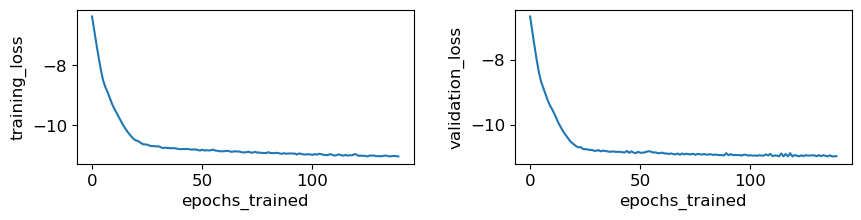

In [283]:
from sbi.analysis import plot_summary

_ = plot_summary(
    inference,
    tags=["training_loss", "validation_loss"],
    figsize=(10, 2),
)

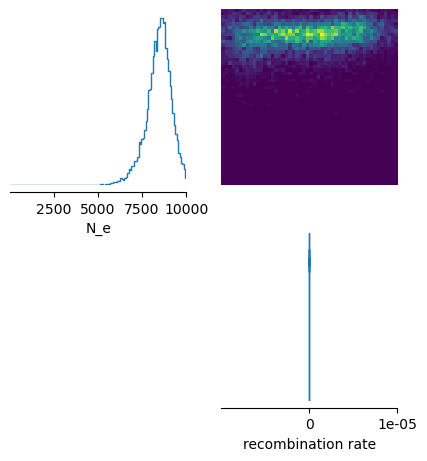

In [282]:
_ = pairplot(
    samples,
    limits=[[10, 1e4], [1e-9, 1e-8]],
    figsize=(5, 5),
    labels=[r"N_e", r"recombination rate"],
)

### Posterior predictive checks

In [226]:
posterior_samples = posterior.sample((10,), x=x_o)
posterior_predictives = simulator(posterior_samples[:,0], posterior_samples[:,1])

  0%|          | 0/10 [00:00<?, ?it/s]

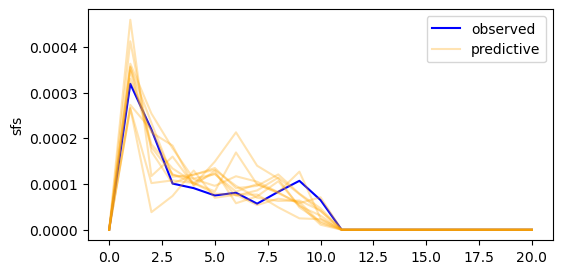

In [267]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
_ = ax.plot(x_o, c='blue')
for i in range(10): 
    _ = ax.plot(posterior_predictives[i].squeeze(), alpha=0.3, c='orange')
_ = ax.legend(["observed", "predictive"])
_ = ax.set_ylabel("sfs")
_ = plt.show()

## Calibration?